# Integration via Green's theorem

In this notebook we validate our expressions for the occultation solution vector, $\mathbb{s}^\top$, which we compute using Green's theorem.

In [1]:
%matplotlib inline

In [2]:
%run notebook_setup.py

In [64]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
import sympy
from tqdm.notebook import tqdm

np.seterr(invalid="ignore", divide="ignore");

## The Green's basis

First off, here's the Green's basis from the original `starry` paper (Equation 11 in [Luger et al. 2019](https://arxiv.org/pdf/1810.06559.pdf)):

In [4]:
def g(x, y, z=None, n=0):
    """
    Return the nth term of the Green's basis (a scalar).
    
    """
    if z is None:
        z = np.sqrt(1 - x ** 2 - y ** 2)
    l = int(np.floor(np.sqrt(n)))
    m = n - l * l - l
    mu = l - m
    nu = l + m
    if (nu % 2 == 0):
        I = [mu // 2]
        J = [nu // 2]
        K = [0]
        C = [(mu + 2) // 2]
    elif (l == 1) and (m == 0):
        I = [0]
        J = [0]
        K = [1]
        C = [1]
    elif (mu == 1) and (l % 2 == 0):
        I = [l - 2]
        J = [1]
        K = [1]
        C = [3]
    elif (mu == 1):
        I = [l - 3, l - 1, l - 3]
        J = [0, 0, 2]
        K = [1, 1, 1]
        C = [-1, 1, 4]
    else:
        I = [(mu - 5) // 2, (mu - 5) // 2, (mu - 1) // 2]
        J = [(nu - 1) // 2, (nu + 3) // 2, (nu - 1) // 2]
        K = [1, 1, 1]
        C = [(mu - 3) // 2, -(mu - 3) // 2, -(mu + 3) // 2]
    res = 0
    for i, j, k, c in zip(I, J, K, C):
        res += c * x ** i * y ** j * z ** k
    return res

For reference, here are the terms in the basis up to degree 3:

In [5]:
x, y, z = sympy.symbols("x y z")
for n in range(16):
    display(g(x, y, z, n))

1

2*x

z

y

3*x**2

-3*x*z

2*x*y

3*y*z

y**2

4*x**3

-4*x**2*z - y**2*z + z

3*x**2*y

-3*x*y*z

2*x*y**2

x**2*z + 4*y**2*z - z

y**3

## Numerical 2D integration

Let's define a function to integrate these terms numerically. Recall that the vector $\mathbb{s}^\top$ is the integral of the Green's basis over some region bounded by the limb of the occultor, the day/night terminator, and the limb of the occulted body. The integral is a function of the terminator parameters $b$ and $\theta$ and the occultor parameters $b_o$ and $r_o$. Recall that the integration is performed in the frame $\mathcal{F}'$, in which the occultor lies along the $+y'$-axis.

For simplicity, let's code up a brain-dead brute force integrator on a grid:

In [61]:
def sT_numerical(b, theta, bo, ro, n=0, res=300):

    # Create a fine grid
    pts = np.linspace(-1, 1, res)
    x, y = np.meshgrid(pts, pts)

    # Check if a point is inside the unit disk
    in_disk = x ** 2 + y ** 2 <= 1

    # Check if a point is under the occultor
    under_occultor = x ** 2 + (y - bo) ** 2 <= ro ** 2

    # Check if a point is on the dayside
    xr = x * np.cos(theta) + y * np.sin(theta)
    yr = -x * np.sin(theta) + y * np.cos(theta)
    term = 1 - xr ** 2
    yt = b * np.sqrt(term)
    on_dayside = yr >= yt
    
    # Now, compute the nth term in the basis...
    term = g(x, y, n=n)
    
    # And sum it over the integration region
    # Each pixel has area dA = (area of square) / (number of pixels)
    dA = 4 / (x.shape[0] * x.shape[1])
    integral = np.nansum(term[in_disk & under_occultor & on_dayside] * dA)
    
    return integral

## 1D integration via Green's theorem

Now, as in Luger et al. (2019), it is straightforward to compute the anti-exterior derivatives of all the terms in this basis, which we can use to transform the 2D surface integrals into 1D line integrals along the boundary. The function `G` below returns the anti-exterior derivative of `g`:

In [33]:
def G(n):
    """
    Return the anti-exterior derivative of the nth term of the Green's basis.
    This is a two-dimensional (Gx, Gy) vector of functions of x and y.
    
    """
    # Get the mu, nu indices
    l = int(np.floor(np.sqrt(n)))
    m = n - l * l - l
    mu = l - m
    nu = l + m

    # NOTE: The abs prevents NaNs when the argument of the sqrt is
    # zero but floating point error causes it to be ~ -eps.
    z = lambda x, y: np.maximum(1e-12, np.sqrt(np.abs(1 - x ** 2 - y ** 2)))

    if nu % 2 == 0:
        
        G = [lambda x, y: 0, lambda x, y: x ** (0.5 * (mu + 2)) * y ** (0.5 * nu)]
    
    elif (l == 1) and (m == 0):

        def G0(x, y):
            z_ = z(x, y)
            if z_ > 1 - 1e-8:
                return -0.5 * y
            else:
                return (1 - z_ ** 3) / (3 * (1 - z_ ** 2)) * (-y)

        def G1(x, y):
            z_ = z(x, y)
            if z_ > 1 - 1e-8:
                return 0.5 * x
            else:
                return (1 - z_ ** 3) / (3 * (1 - z_ ** 2)) * x

        G = [G0, G1]

    elif (mu == 1) and (l % 2 == 0):
        
        G = [lambda x, y: x ** (l - 2) * z(x, y) ** 3, lambda x, y: 0]
    
    elif (mu == 1) and (l % 2 != 0):
        
        G = [lambda x, y: x ** (l - 3) * y * z(x, y) ** 3, lambda x, y: 0]
    
    else:
        
        G = [
            lambda x, y: 0,
            lambda x, y: x ** (0.5 * (mu - 3))
            * y ** (0.5 * (nu - 1))
            * z(x, y) ** 3,
        ]
        
    return G

We show in the paper how we can write $\mathbb{s}^\top$ as the sum of the integrals along each of the boundaries, $\mathbb{p}^\top$, $\mathbb{t}^\top$, and $\mathbb{q}^\top$. Below we use the expressions from the paper to construct those integrals. For simplicity, we integrate them numerically in this notebook; we derive analytic expressions later in the text (with their own accompanying notebooks).

In [34]:
def primitive(x, y, dx, dy, theta1, theta2, n=0):
    """A general primitive integral computed numerically."""

    def func(theta):
        Gx, Gy = G(n)
        return Gx(x(theta), y(theta)) * dx(theta) + Gy(x(theta), y(theta)) * dy(theta)

    res, _ = quad(func, theta1, theta2, epsabs=1e-12, epsrel=1e-12)
    return res


def pT(phi, bo, ro, n=0):
    """Compute the pT integral numerically from its integral definition."""
    res = 0
    for phi1, phi2 in phi.reshape(-1, 2):
        x = lambda phi: ro * np.cos(phi)
        y = lambda phi: bo + ro * np.sin(phi)
        dx = lambda phi: -ro * np.sin(phi)
        dy = lambda phi: ro * np.cos(phi)
        res += primitive(x, y, dx, dy, phi1, phi2, n)
    return res


def tT(xi, b, theta, n=0):
    """Compute the tT integral numerically from its integral definition."""
    res = 0
    for xi1, xi2 in xi.reshape(-1, 2):
        x = lambda xi: np.cos(theta) * np.cos(xi) - b * np.sin(theta) * np.sin(xi)
        y = lambda xi: np.sin(theta) * np.cos(xi) + b * np.cos(theta) * np.sin(xi)
        dx = lambda xi: -np.cos(theta) * np.sin(xi) - b * np.sin(theta) * np.cos(xi)
        dy = lambda xi: -np.sin(theta) * np.sin(xi) + b * np.cos(theta) * np.cos(xi)
        res += primitive(x, y, dx, dy, xi1, xi2, n)
    return res


def qT(lam, n=0):
    """Compute the qT integral numerically from its integral definition."""
    res = 0
    for lam1, lam2 in lam.reshape(-1, 2):
        x = lambda lam: np.cos(lam)
        y = lambda lam: np.sin(lam)
        dx = lambda lam: -np.sin(lam)
        dy = lambda lam: np.cos(lam)
        res += primitive(x, y, dx, dy, lam1, lam2, n)
    return res

def sT(phi, xi, lam, b, theta, bo, ro, n=0):
    """The solution vector for occultations, computed via Green's theorem."""
    return pT(phi, bo, ro, n) + tT(xi, b, theta, n) + qT(lam, n)

## Validation

For definiteness, let's compute the integral over the region shown in Figure 16 of the paper. The parameters in that figure are

In [35]:
b = 0.5
theta = 75 * np.pi / 180
bo = 0.5
ro = 0.7

Here's what the geometry looks like:

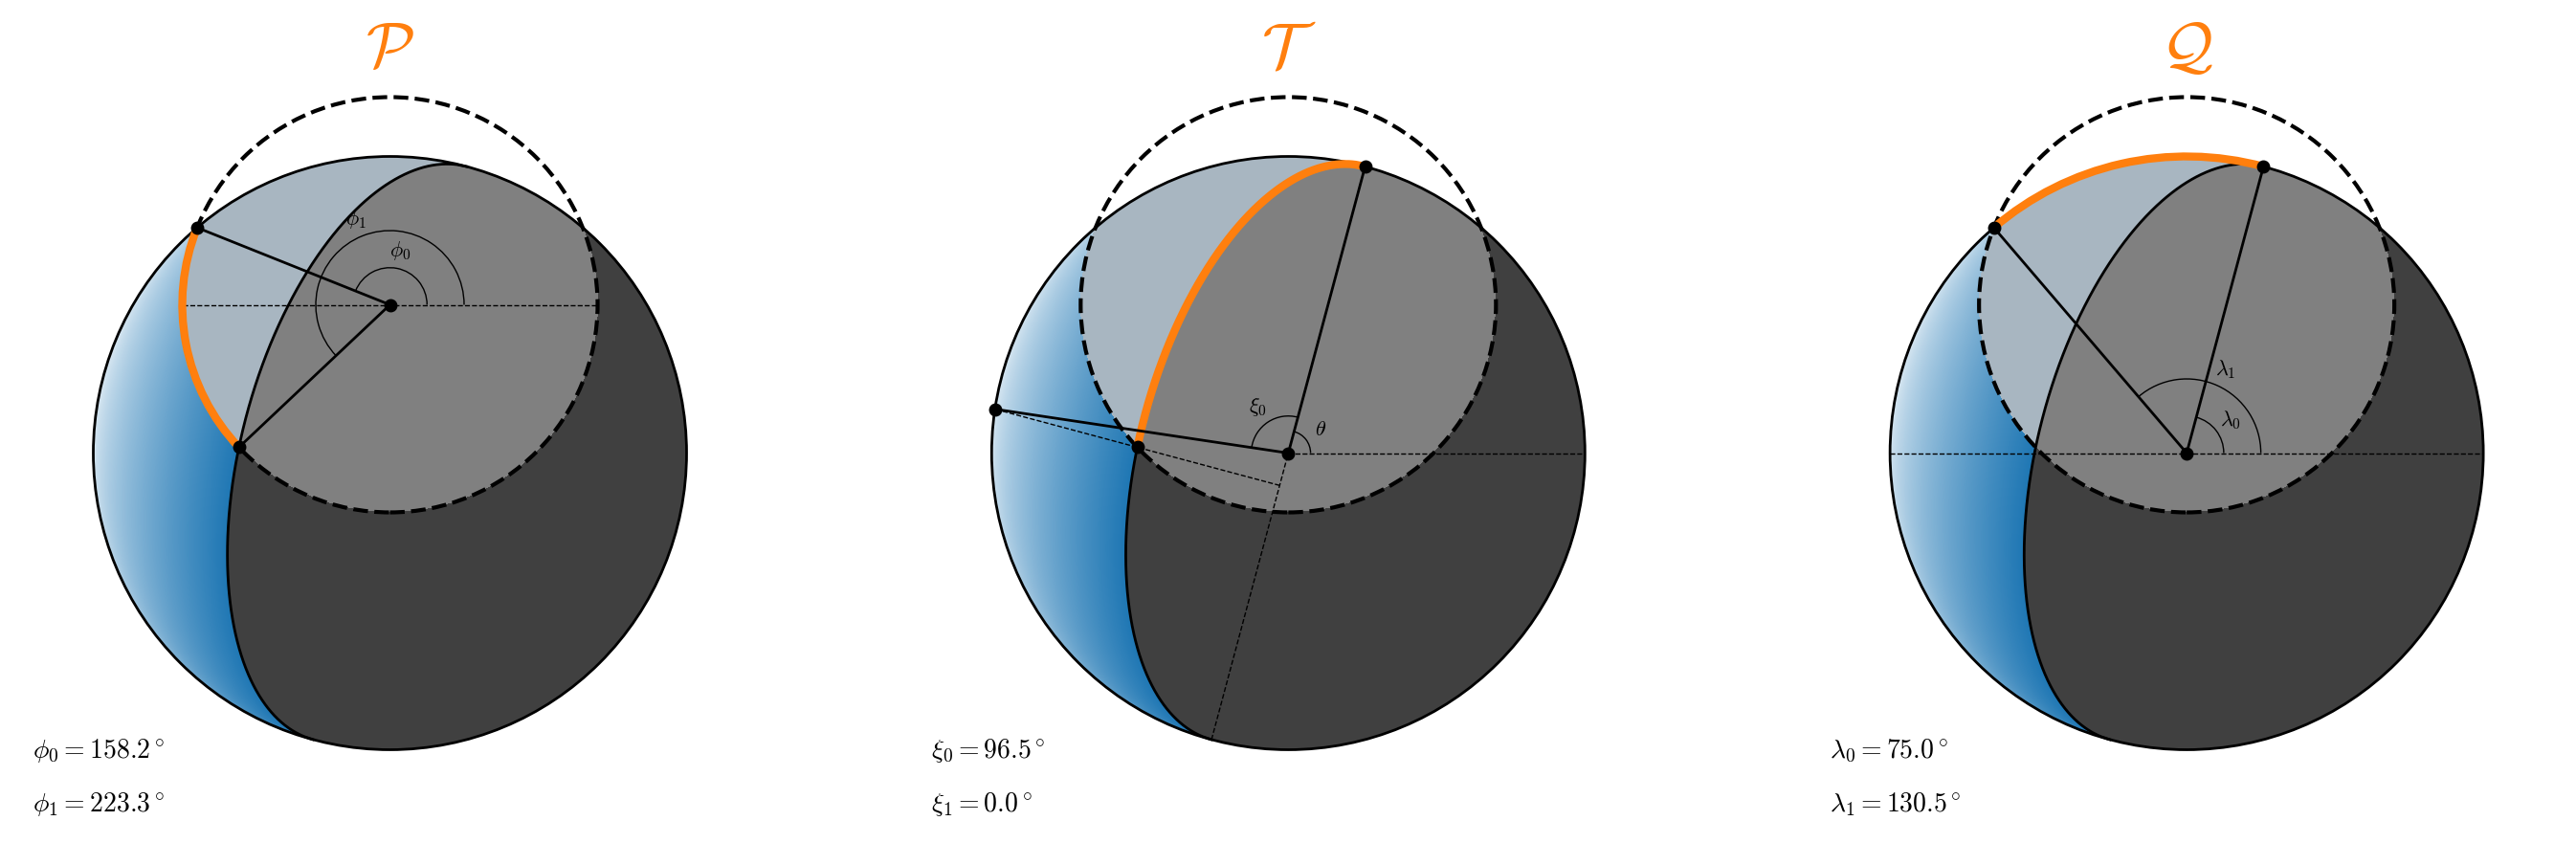

In [22]:
import sys
import os
sys.path.insert(1, os.path.abspath("../figures/support_code"))
from support_code import visualize
visualize(b, theta, bo, ro);

We're going to compute the integral over the region bounded by P, T, and Q. Let's take note of those angles here:

In [36]:
phi = np.array([158.19625201, 223.34183756]) * np.pi / 180
xi = np.array([96.48097513, 0.0]) * np.pi / 180
lam = np.array([75.0, 130.53580211]) * np.pi / 180

First, let's compute the numerical integrals up to $n = 16$ (i.e., spherical harmonic degree 3). We'll do it at very high resolution (4999 grid points on a side, or 25 million points).

In [65]:
numerical = np.zeros(16)
for n in tqdm(range(16)):
    numerical[n] = sT_numerical(b, theta, bo, ro, n=n, res=4999)

Now let's compute it via Green's theorem (note how much faster this is, even though we're still computing the integral numerically):

In [53]:
analytic = np.zeros(16)
for n in tqdm(range(16)):
    analytic[n] = sT(phi, xi, lam, b, theta, bo, ro, n=n)

Finally, let's compare the two solutions:

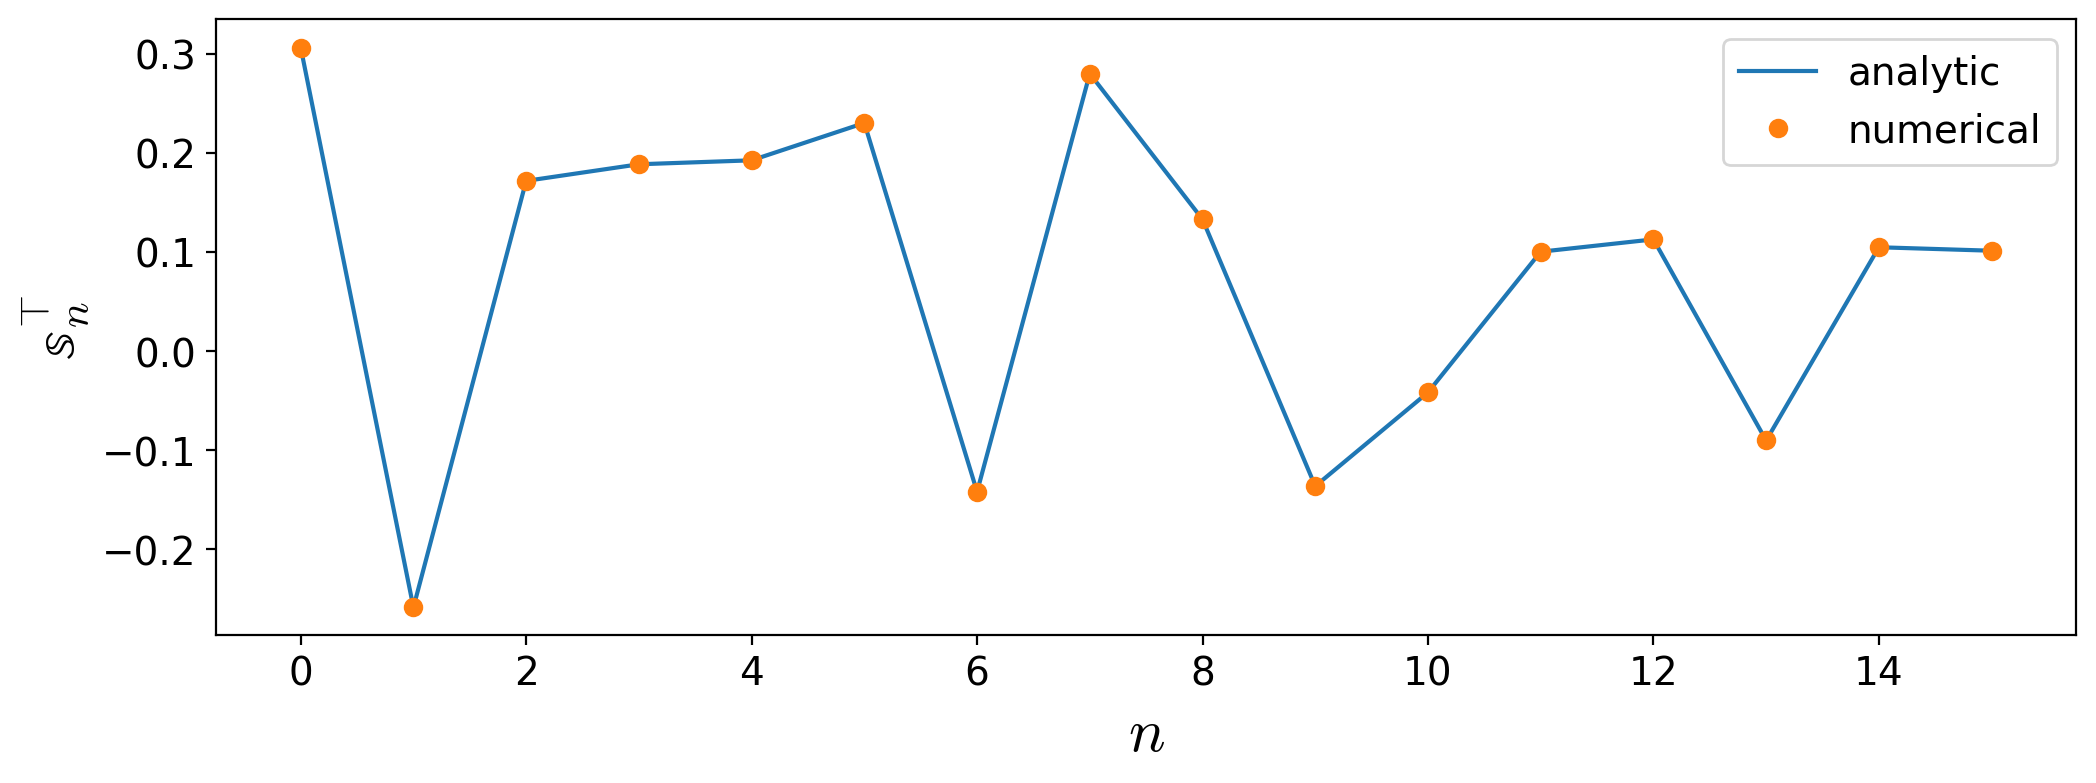

In [70]:
plt.plot(analytic, label="analytic")
plt.plot(numerical, "C1o", label="numerical")
plt.legend()
plt.xlabel(r"$n$", fontsize=22)
plt.ylabel(r"$\mathbb{s}_n^\top$", fontsize=22);

They agree! Here's the difference between the two, which is set by the numerical precision of the brute force integration:

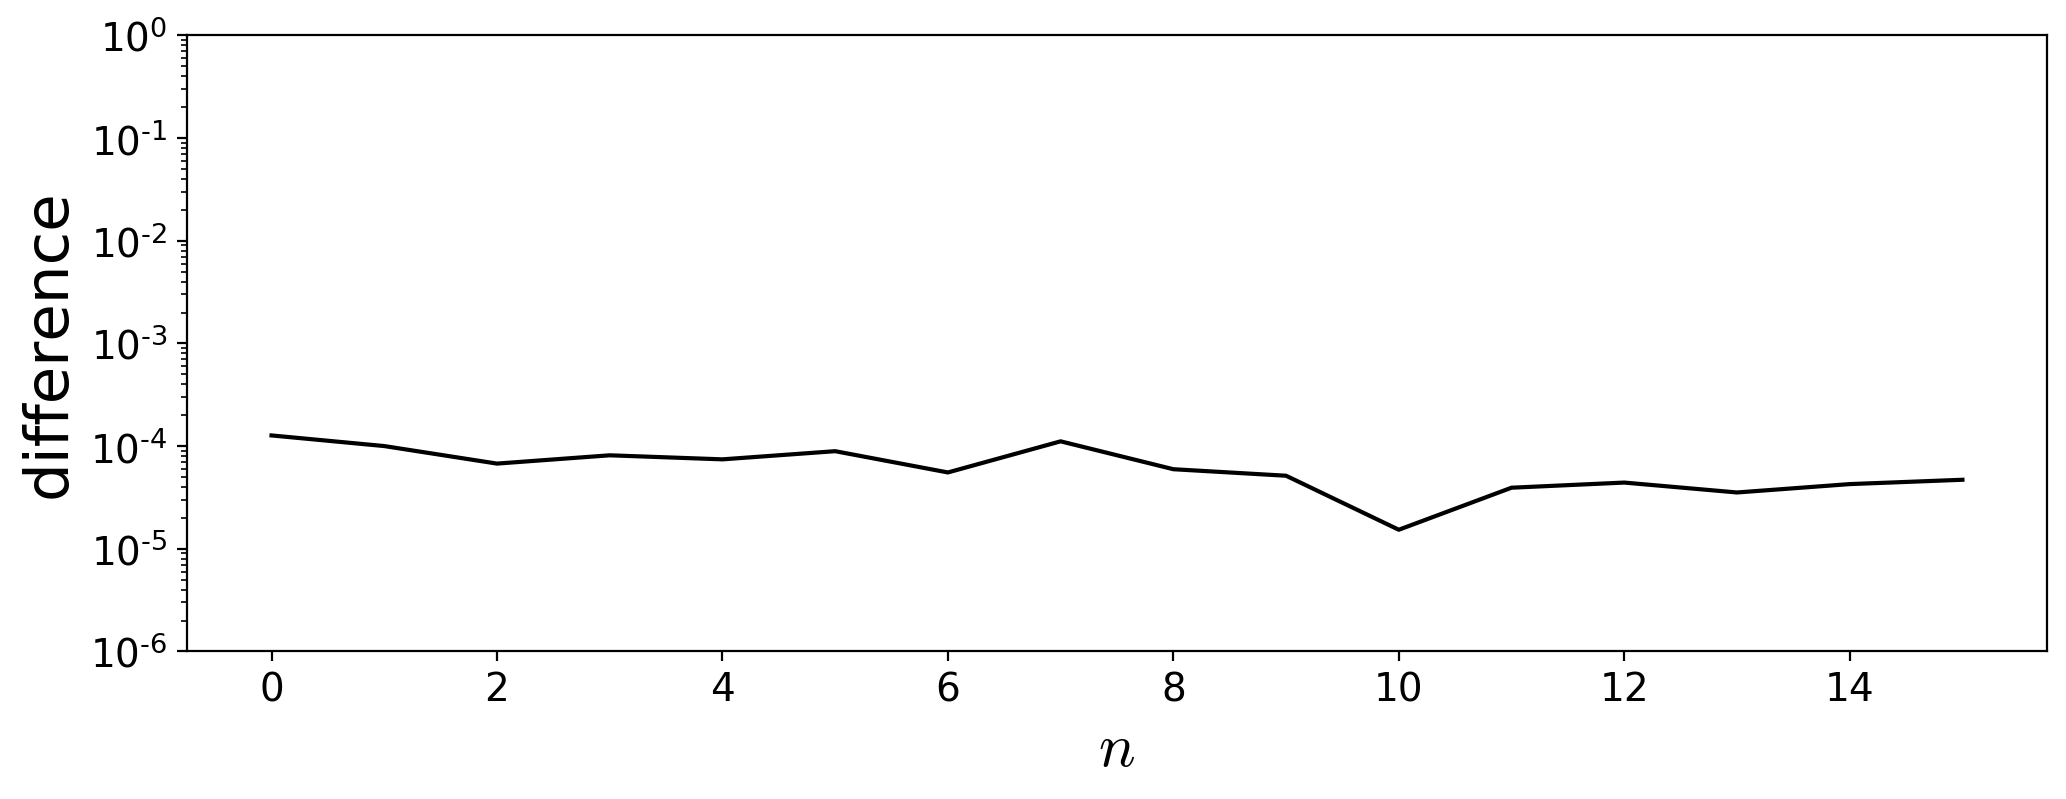

In [69]:
plt.plot(np.abs(analytic - numerical), "k-")
plt.yscale("log")
plt.xlabel(r"$n$", fontsize=22)
plt.ylabel(r"difference", fontsize=22)
plt.ylim(1e-6, 1e0);